In [87]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import csv
import sqlite3 as sql
import math
import statsmodels.api as sm
%matplotlib inline

In [74]:
#Pull HTML from UN website and parse
r = requests.get("http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm")
soup = BeautifulSoup(r.content,'html.parser')

In [75]:
#Extract data at appropriate level in structure
urlData=[]
for i in soup('table')[6]('tr'):
    #The groups of interest have a length of 25, hence this filter to exclude items not needed
    if len(i) == 25:
        urlData.append(i)

In [76]:
#Manipulate HTML data into DataFrame
colList=['Country','Year','Total','Men','Women']
tableData = pd.DataFrame(columns=['Country','Year','Total','Men','Women'])

i=0
for entry in urlData:
    tableData.loc[i]=[int(entry('td')[v].get_text()) if v > 1 else entry('td')[v].get_text() for v in [0,1,4,7,10]]
    i+=1

#Set country as index and drop old column
tableData=tableData.set_index(tableData['Country'])
tableData=tableData.drop(['Country'],1)

Mean School Life Expectancy for Total is 12.45
Median School Life Expectancy for Total is 13.00
Normality Test P-Value for Total is 0.44

Mean School Life Expectancy for Men is 12.39
Median School Life Expectancy for Men is 12.00
Normality Test P-Value for Men is 0.42

Mean School Life Expectancy for Women is 12.51
Median School Life Expectancy for Women is 13.00
Normality Test P-Value for Women is 0.06

Null Hypothesis: School Life Expectancy is equivalent for Men and Women regardless of country
T-Test P-Value: 0.72
Null Hypothesis Accepted


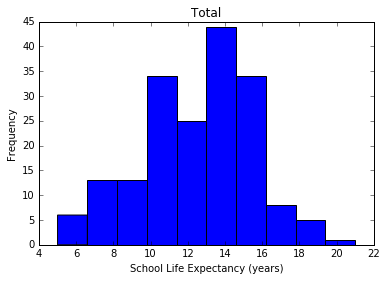

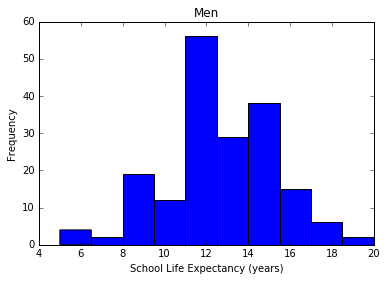

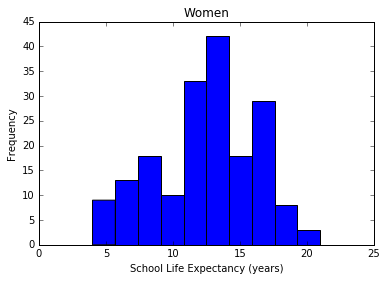

In [77]:
#Evaluate the data captured from the UN on school life
for col in colList[2::]:
    s,p = sts.normaltest(tableData[col])
    print('Mean School Life Expectancy for %s is %0.2f' % (col,tableData[col].mean()))
    print('Median School Life Expectancy for %s is %0.2f' % (col,tableData[col].median()))
    print('Normality Test P-Value for %s is %0.2f\n' % (col,p))
    
    plt.figure()
    plt.hist(tableData[col])
    plt.title(col)
    plt.xlabel('School Life Expectancy (years)')
    plt.ylabel('Frequency')

#T-Test of Null Hypothesis
s,p = sts.ttest_ind(tableData['Men'],tableData['Women'])
print('Null Hypothesis: School Life Expectancy is equivalent for Men and Women regardless of country')
print('T-Test P-Value: %0.2f' % p)
if p > .05:
    print('Null Hypothesis Accepted')
else:
    print('Null Hypothesis REEEEjected!')


In [78]:
#Pull World Bank data into a DataFrame
fileName='API_NY.GDP.MKTP.CD_DS2_en_csv_v2.csv'
moneyData=pd.read_csv(fileName,header=2,usecols=['Country Name','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010'])

#Relabel the DataFrame index & drop Country Name column
moneyData=moneyData.set_index(moneyData['Country Name'])
moneyData=moneyData.drop('Country Name',1)
#Make index name SQLite friendly
moneyData.index.names= ['CountryName']

#Make column names SQLite friendly
colname=[]
for yr in range(1999,2011):
    colname.append('_'+str(yr))
moneyData.columns = colname

#Create database
con = sql.connect('WorldBankData.db')
cur = con.cursor()

#Create function to deal with SQLite weirdness about Unicode & text_factory
con.text_factory = lambda x: unicode(x,'utf-8','ignore')

#Push moneyData DataFrame into the database
cur.execute('DROP TABLE IF EXISTS gdp;')
moneyData.to_sql('gdp',con,flavor='sqlite')

#Push tableData DataFrame into the database
cur.execute('DROP TABLE IF EXISTS education;')
tableData.to_sql('education',con,flavor='sqlite')

In [79]:
#Generate selection for join
slct=''
for yr in range(1999,2011):
    slct=slct+',gdp._'+str(yr)

#Query database and insert into DataFrame
joinData=pd.read_sql('SELECT education.Country,education.Year,education.Total'+slct+' FROM education INNER JOIN gdp ON education.Country = gdp.CountryName ',con)

In [80]:
#Match Education Year & GDP Year and pull GDP for that year
joinData['gdp']=[joinData.loc[idx]['_'+str(joinData.loc[idx][1])] for idx in joinData.index]

#Generate list to drop....
slct=[]
for yr in range(1999,2011):
    slct.append('_'+str(yr))
#...and drop them
joinData=joinData.drop(slct,1)

In [84]:
#Perform log transform and store in new column
joinData['gdp_log']=[math.log(x) for x in joinData['gdp']]
joinData['Total_log']=[math.log(x) for x in joinData['Total']]

In [129]:
results.params

array([ nan,  nan])

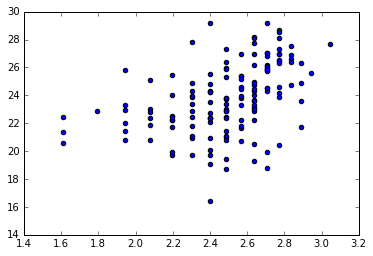

In [126]:
#Linear Regression
x=[x for x in joinData['Total_log']]
y=[y for y in joinData['gdp_log']]
x=sm.add_constant(x)
model=sm.OLS(y,x)
results=model.fit()

mX=[]
for i in range(1,11):
    mX.append(i*0.1+round(min(joinData['Total_log']),1))

mY=[float(results.params[0]) + float(results.params[1])*x for x in mX]

plt.scatter(joinData['Total_log'],joinData['gdp_log'])
plt.plot(mX,mY)